In [2]:
import cv2
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Multiply, Add, Reshape
from tensorflow.keras.applications import EfficientNetB0
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_ar

In [3]:
#Data Augmentation
def create_tf_dataset(directory, batch_size=8, img_size=(256, 256)):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.7, 1.3],
        validation_split=0.2
    )

    train_dataset = datagen.flow_from_directory(
        directory,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    val_dataset = datagen.flow_from_directory(
        directory,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    return train_dataset, val_dataset

In [4]:
 train_dir = r'W:\\CU\\SEMESTER 6\\Research Paper 2\\CT scans\\Archive\\DATASET\\train'
val_dir = r'W:\\CU\\SEMESTER 6\\Research Paper 2\\CT scans\\Archive\\DATASET\\val'

train_dataset, val_dataset = create_tf_dataset(train_dir)

#Dynamically Fetch Number of Classes
labels = list(train_dataset.class_indices.keys())
num_classes = len(labels)

print(f"Dataset Labels: {labels}, Num Classes: {num_classes}")

#SCNet Components
class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.conv1 = Conv2D(1, (7, 7), activation='sigmoid', padding='same')

    def call(self, inputs):
        print(f"SpatialAttention Input Shape: {inputs.shape}")  # Debugging Tensor Shape
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.keras.layers.Concatenate(axis=-1)([avg_pool, max_pool])
        attention_map = self.conv1(concat)
        return Multiply()([inputs, attention_map])

class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, channels, reduction=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.shared_dense = Dense(channels // reduction, activation='relu')
        self.output_dense = Dense(channels, activation='sigmoid')

    def call(self, inputs):
        avg_pool = GlobalAveragePooling2D()(inputs)
        max_pool = GlobalMaxPooling2D()(inputs)

        avg_pool = tf.expand_dims(tf.expand_dims(avg_pool, axis=1), axis=1)
        max_pool = tf.expand_dims(tf.expand_dims(max_pool, axis=1), axis=1)

        scale_avg = self.shared_dense(avg_pool)
        scale_max = self.shared_dense(max_pool)
        scale = Add()([scale_avg, scale_max])
        scale = self.output_dense(scale)

        return Multiply()([inputs, scale])


Found 4710 images belonging to 2 classes.
Found 1177 images belonging to 2 classes.
Dataset Labels: ['Normal', 'Tumor'], Num Classes: 2


In [5]:
#EfficientNet Feature Extraction with Dynamic Channels
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
channels = base_model.output_shape[-1]

x = base_model.output
x = ChannelAttention(channels)(x)  # Apply Channel Attention
x = SpatialAttention()(x)  # Apply Spatial Attention

x = GlobalAveragePooling2D()(x)  # Replace Flatten for efficiency
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005))(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = Dense(num_classes, activation='softmax')(x)


SpatialAttention Input Shape: (None, 8, 8, 1280)
SpatialAttention Input Shape: (None, 8, 8, 1280)


Epoch 1/5
SpatialAttention Input Shape: (None, 8, 8, 1280)
SpatialAttention Input Shape: (None, 8, 8, 1280)


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 864ms/step - accuracy: 0.7660 - loss: 0.8622SpatialAttention Input Shape: (None, 8, 8, 1280)
589/589 ━━━━━━━━━━━━━━━━━━━━ 583s 925ms/step - accuracy: 0.7661 - loss: 0.8618 - val_accuracy: 0.8556 - val_loss: 0.5053
Epoch 2/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 604s 1s/step - accuracy: 0.9375 - loss: 0.3409 - val_accuracy: 0.8649 - val_loss: 0.5527
Epoch 3/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 703s 1s/step - accuracy: 0.9614 - loss: 0.2444 - val_accuracy: 0.8496 - val_loss: 0.6908
Epoch 4/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 680s 1s/step - accuracy: 0.9773 - loss: 0.1899 - val_accuracy: 0.8573 - val_loss: 0.9190
Epoch 5/5
589/589 ━━━━━━━━━━━━━━━━━━━━ 710s 1s/step - accuracy: 0.9804 - loss: 0.1499 - val_accuracy: 0.8777 - val_loss: 0.4164
SpatialAttention Input Shape: (8, 8, 8, 1280)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 

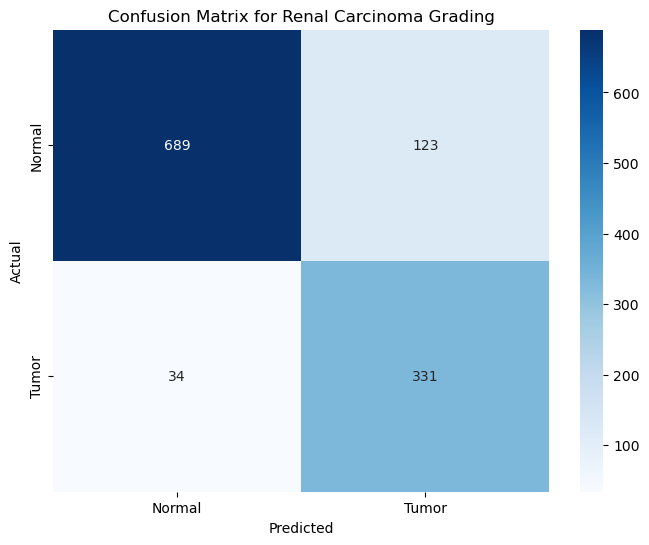

In [6]:
#Build SCNet-Enhanced Model
model = Model(inputs=base_model.input, outputs=x)

#Compile Model with AdamW & Class Weights
optimizer = optimizers.AdamW(learning_rate=0.0005, weight_decay=1e-5)
class_weights = {0: 1.2, 1: 0.8}

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5, class_weight=class_weights)

#Confusion Matrix & Classification Report
y_true, y_pred = [], []
for i in range(len(val_dataset)):
    x_batch, y_batch = val_dataset[i]
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(model.predict(x_batch), axis=1))

conf_matrix = confusion_matrix(y_true, y_pred)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Renal Carcinoma Grading')
plt.show()

In [9]:
#Grad-CAM
def grad_cam(model, img_path):
    img = load_img(img_path, target_size=(256, 256))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    grad_model = Model([model.input], [model.get_layer('block6a_project_conv').output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions)]

    grads = tape.gradient(loss, conv_outputs)
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))
    activation_map = np.squeeze(conv_outputs.numpy())

    cam = np.dot(activation_map, weights.numpy())
    cam = cv2.resize(cam, (256, 256))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlayed_img = cv2.addWeighted(np.uint8(img_array[0] * 255), 0.6, heatmap, 0.4, 0)

    plt.figure()
    plt.imshow(overlayed_img)
    plt.axis('off')
    plt.title(f"Grad-CAM for {labels[np.argmax(predictions)]}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
SpatialAttention Input Shape: (1, 8, 8, 1280)


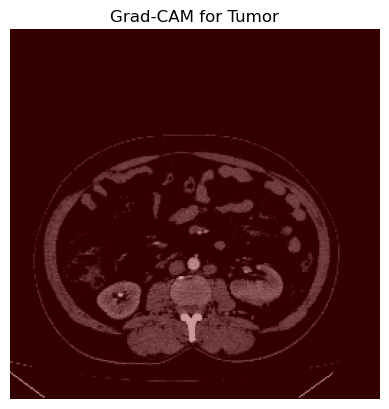

SpatialAttention Input Shape: (1, 8, 8, 1280)


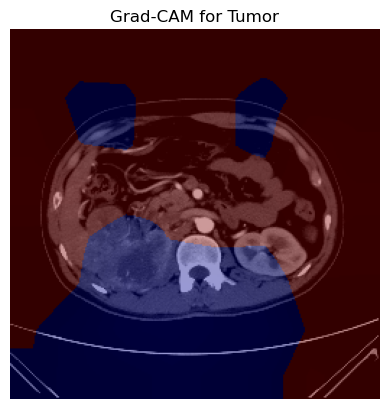

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
SpatialAttention Input Shape: (1, 8, 8, 1280)


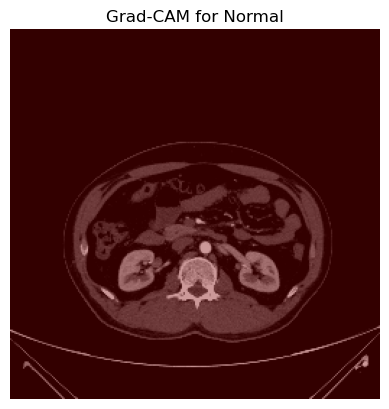

SpatialAttention Input Shape: (1, 8, 8, 1280)


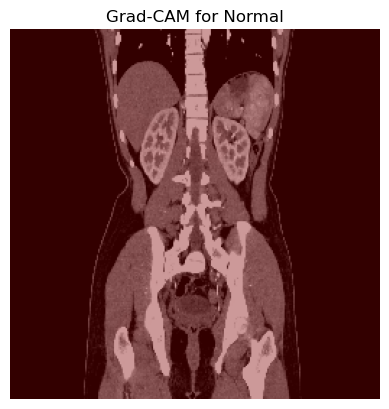

SpatialAttention Input Shape: (1, 8, 8, 1280)


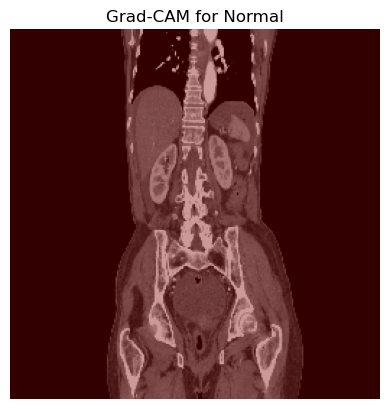

SpatialAttention Input Shape: (1, 8, 8, 1280)


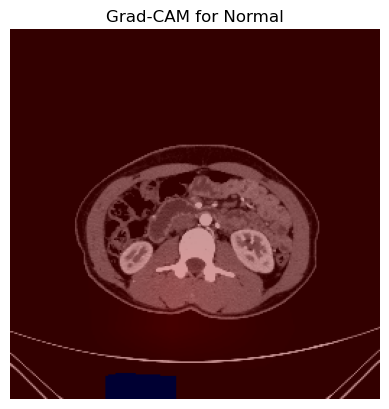

SpatialAttention Input Shape: (1, 8, 8, 1280)


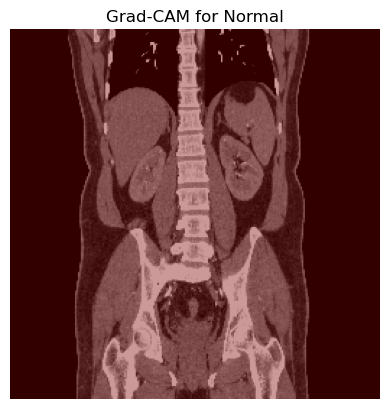

In [10]:
# 🔹 Highlight Top Malignant & Normal Tumors
def highlight_top_predictions(category_index, num_samples=5):
    correct_images = []
    
    for _ in range(10):  
        img_path = val_dataset.filepaths[np.random.randint(len(val_dataset.filepaths))]
        img = load_img(img_path, target_size=(256, 256))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction)
        actual_class = labels.index(img_path.split("\\")[-2])

        if predicted_class == category_index and actual_class == category_index:
            correct_images.append((img_path, prediction[0][category_index]))

    correct_images = sorted(correct_images, key=lambda x: x[1], reverse=True)[:num_samples]
    
    for img_path, confidence in correct_images:
        grad_cam(model, img_path)

highlight_top_predictions(1, 5)
highlight_top_predictions(0, 5)

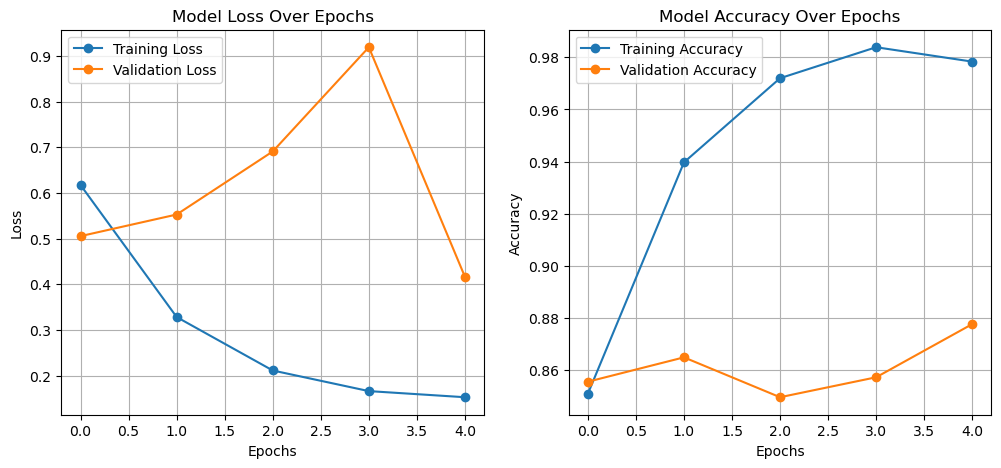

In [11]:
# Plot Training Loss and Accuracy
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.grid()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.grid()

plt.show()
